In [230]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib.parse import quote_plus
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pyodbc

<br><h3>Підключення до сховища даних</h3>

In [2]:
# Create the connection string
username = "administrator"
password = "administrator"
server = "DESKTOP-MLG7MPI\MSSQLSERVER01"
database = "UFCStorage"

# Properly encode the connection string
params = quote_plus(
    f"DRIVER=ODBC Driver 17 for SQL Server;"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

In [194]:
query = """
SELECT * 
FROM 
(
	SELECT fightID, fighterRedID, fighterBlueID, winner 
	FROM fact_Fight
) AS t
INNER JOIN 
(
	SELECT 
		fighterID, wins as rWins, losses as rLosses, draws as rDraws, 
		height as rHeight, reach as rReach, weight as rWeight,
		stanceID as rStanceID,
		sigStrAcc as rSigStrAcc, sigStrDef as rSigStrDef, 
		tdAcc as rTdAcc, tdDef as rTdDef, avgSubAtt as rAvgSubAtt,
		dateOfBirth as rDOB
	FROM dim_Fighter
) AS r
ON fighterRedID = r.fighterID
INNER JOIN 
(
	SELECT 
		fighterID, wins as bWins, losses as bLosses, draws as bDraws, 
		height as bHeight, reach as bReach, weight as bWeight,
		stanceID as bStanceID,
		sigStrAcc as bSigStrAcc, sigStrDef as bSigStrDef, 
		tdAcc as bTdAcc, tdDef as bTdDef, avgSubAtt as bAvgSubAtt,
		dateOfBirth as bDOB
	FROM dim_Fighter
) AS b
ON fighterBlueID = b.fighterID

SELECT 
	fighterID, wins as rWins, losses as rLosses, draws as rDraws, 
	height as rHeight, reach as rReach, stanceID as rStanceID,
	sigStrAcc as rSigStrAcc, sigStrDef as rSigStrAcc, 
	tdAcc as rTdAcc, tdDef as rTdDef, avgSubAtt as rAvgSubAtt,
	dateOfBirth as rDOB
FROM dim_Fighter"""

df = pd.read_sql(query, engine)
df

,fightID,fighterRedID,fighterBlueID,winner,fighterID,rWins,rLosses,rDraws,rHeight,rReach,...,bHeight,bReach,bWeight,bStanceID,bSigStrAcc,bSigStrDef,bTdAcc,bTdDef,bAvgSubAtt,bDOB
0,1,969,1151,B,969,12,4,0,160,167,...,165,165,56,3,40,62,48,60,0,19920629.0
1,2,2445,3599,R,2445,9,1,0,190,200,...,182,187,119,4,55,49,0,100,0,19931213.0
2,3,1139,1505,R,1139,12,4,0,187,190,...,185,193,83,3,47,47,75,64,0,19920118.0
3,4,1135,932,R,1135,7,0,0,177,177,...,172,170,61,4,46,55,36,44,0,20001220.0
4,5,580,653,B,580,18,5,0,177,177,...,177,182,61,5,48,64,31,60,1,19960904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7401,7402,2027,3912,R,2027,1,5,0,177,182,...,187,192,111,3,0,0,0,0,0,NaN
7402,7403,2966,3104,R,2966,1,0,0,178,182,...,190,195,95,3,0,0,0,0,0,NaN
7403,7404,3223,2212,R,3223,2,1,0,182,187,...,195,200,124,3,0,0,0,0,0,NaN
7404,7405,3506,3565,R,3506,20,17,0,187,192,...,178,182,77,3,0,0,0,0,0,NaN


In [171]:
query = """
select date, winner
from fact_Fight
inner join dim_Event on fact_Fight.eventID = dim_Event.eventID
inner join dim_Date on eventDateID = dateID
order by date
"""

wins_over_time = pd.read_sql(query, engine)
wins_over_time

,date,winner
0,1994-03-11,R
1,1994-03-11,R
2,1994-03-11,R
3,1994-03-11,R
4,1994-03-11,R
...,...,...
7401,2024-03-23,B
7402,2024-03-23,B
7403,2024-03-23,R
7404,2024-03-23,R


<br><h3>Аналіз ознак</h3>

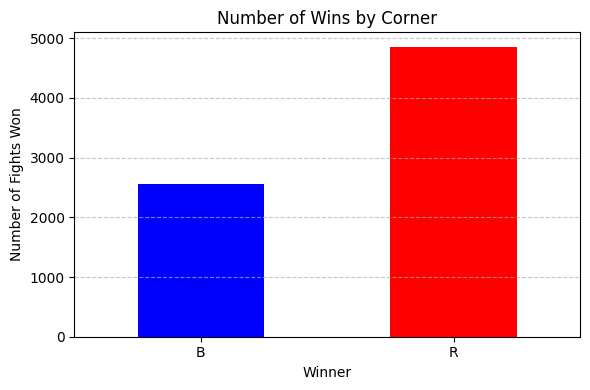

In [172]:
# Count wins by 'R' and 'B'
win_counts = df['winner'].value_counts().sort_index()  # Ensure R/B order

# Plot histogram
plt.figure(figsize=(6, 4))
win_counts.plot(kind='bar', color=['blue', 'red'])

plt.title('Number of Wins by Corner')
plt.xlabel('Winner')
plt.ylabel('Number of Fights Won')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

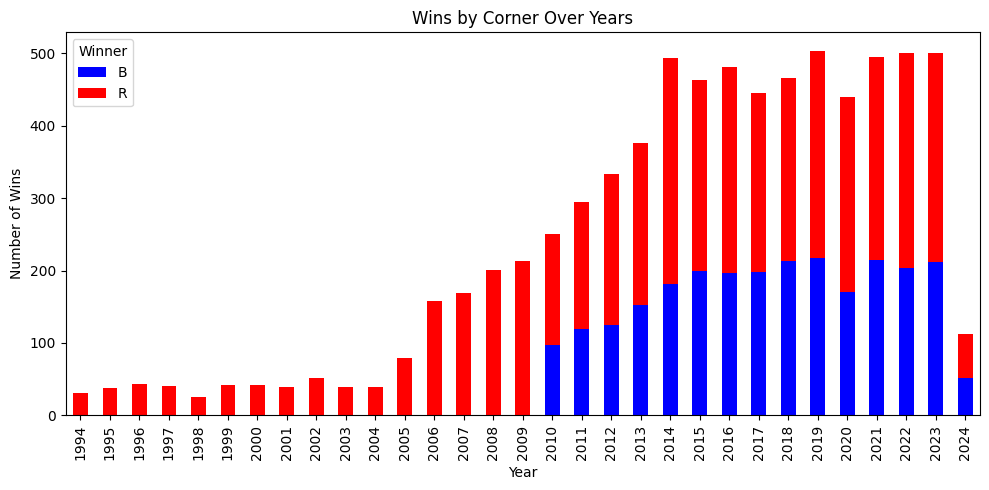

In [173]:
# Make sure 'date' is datetime
wins_over_time['date'] = pd.to_datetime(wins_over_time['date'])

# Group by year and winner
wins_over_time['year'] = wins_over_time['date'].dt.year
wins_per_year = wins_over_time.groupby(['year', 'winner']).size().unstack(fill_value=0)

# Plot
wins_per_year.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 5))

plt.title('Wins by Corner Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Winner')
plt.tight_layout()
plt.show()

In [195]:
df['winner'] = df['winner'].replace({'R': 1, 'B': 0})

C:\Users\Svetlana Nazarko\AppData\Local\Temp\ipykernel_15252\923928451.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'R': 1, 'B': 0})


In [175]:
threshold = 0.6

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Mask the upper triangle and diagonal (to avoid duplicate pairs)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Find pairs with correlation above threshold
high_corr_pairs = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
    .query('Correlation > @threshold')
    .sort_values(by='Correlation', ascending=False)
)

print(high_corr_pairs)

         Feature 1  Feature 2  Correlation
33    fighterRedID  fighterID     1.000000
76   fighterBlueID  fighterID     1.000000
278        rWeight    bWeight     0.911139
451        bHeight     bReach     0.902922
220        rHeight     rReach     0.899711
221        rHeight    rWeight     0.794070
452        bHeight    bWeight     0.772316
243         rReach    rWeight     0.763813
276        rWeight    bHeight     0.754381
30         fightID       bDOB     0.750220
235        rHeight    bWeight     0.747321
460         bReach    bWeight     0.745572
233        rHeight    bHeight     0.727793
277        rWeight     bReach     0.727506
16         fightID       rDOB     0.723940
257         rReach    bWeight     0.717749
234        rHeight     bReach     0.707214
255         rReach    bHeight     0.704480
256         rReach     bReach     0.688071
418          bWins    bLosses     0.675999
145          rWins    rLosses     0.654433
404           rDOB       bDOB     0.650219


<br><h4>Інженерія ознак</h4>

In [196]:
df['rDOB'] = pd.to_datetime(df['rDOB'].dropna().astype(int).astype(str), format='%Y%m%d', errors='coerce')
df['bDOB'] = pd.to_datetime(df['bDOB'].dropna().astype(int).astype(str), format='%Y%m%d', errors='coerce')

reference_date = pd.to_datetime('2030-06-30')
df['rAge'] = (reference_date - df['rDOB']).dt.days 
df['bAge'] = (reference_date - df['bDOB']).dt.days 

In [197]:
df['reach_diff'] = df['rReach'] - df['bReach']
df['height_diff'] = df['rHeight'] - df['bHeight']
df['weight_diff'] = df['rWeight'] - df['bWeight']

df['sig_str_acc_diff'] = df['rSigStrAcc'] - df['bSigStrAcc']
df['sig_str_def_diff'] = df['rSigStrDef'] - df['bSigStrDef']
df['td_acc_diff'] = df['rTdAcc'] - df['bTdAcc']
df['td_def_diff'] = df['rTdDef'] - df['bTdDef']

df['sub_att_diff'] = df['rAvgSubAtt'] - df['bAvgSubAtt']
df['experience_diff'] = (df['rWins'] + df['rLosses'] + df['rDraws']) - (df['bWins'] + df['bLosses'] + df['bDraws'])
df['win_ratio_diff'] = (df['rWins'] / (df['rWins'] + df['rLosses'] + 1)) - (df['bWins'] / (df['bWins'] + df['bLosses'] + 1))

df['age_days_diff'] = df['rAge'] - df['bAge']
df['age_days_diff'] = df['age_days_diff'].fillna(df['age_days_diff'].median())

In [198]:
columns_to_drop = [col for col in df.columns if col.startswith('r') or col.startswith('b')]
X = df.drop(columns=columns_to_drop + ['fightID', 'fighterRedID', 'fighterBlueID', 'fighterID', 'winner'])
y = df['winner']

In [201]:
threshold = 0.3

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Mask the upper triangle and diagonal (to avoid duplicate pairs)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Find pairs with correlation above threshold
high_corr_pairs = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
    .query('Correlation > @threshold')
    .sort_values(by='Correlation', ascending=False)
)

print(high_corr_pairs)

           Feature 1    Feature 2  Correlation
25  sig_str_def_diff  td_def_diff     0.326289


In [180]:
X = X.drop(columns=['wins_diff', 'losses_diff'])

In [181]:
for i in range(len(X)):
    if np.random.randint(1, 3) == 1:
        continue

    X.loc[i] = -X.loc[i]
    y.loc[i] = 1 - y.loc[i]

C:\Users\Svetlana Nazarko\AppData\Local\Temp\ipykernel_15252\454734306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[i] = 1 - y.loc[i]
C:\Users\Svetlana Nazarko\AppData\Local\Temp\ipykernel_15252\454734306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[i] = 1 - y.loc[i]
C:\Users\Svetlana Nazarko\AppData\Local\Temp\ipykernel_15252\454734306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[i] = 1 - y.loc[i

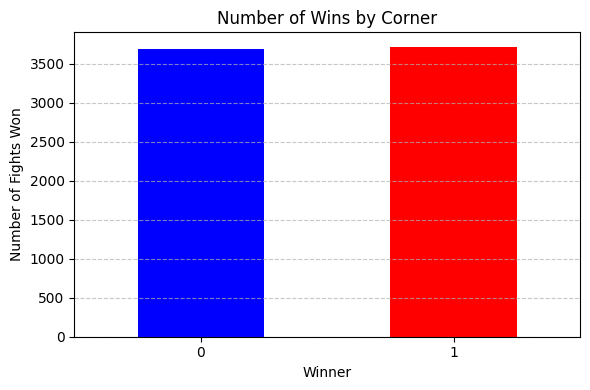

In [184]:
# Count wins by 'R' and 'B'
win_counts = y.value_counts().sort_index()  # Ensure R/B order

# Plot histogram
plt.figure(figsize=(6, 4))
win_counts.plot(kind='bar', color=['blue', 'red'])

plt.title('Number of Wins by Corner')
plt.xlabel('Winner')
plt.ylabel('Number of Fights Won')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<br><h3>Побудова моделей</h3>

<br><h4>Dummy Classifier</h4>

In [235]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier().fit(X_train, y_train)

predict_start_time = time.time()
y_hat_test = model.predict(X_test)
predict_end_time = time.time()

y_hat_train = model.predict(X_train)

print(f"Predict time: {predict_end_time - predict_start_time:.4f} seconds")
print("Train accuaracy:", accuracy_score(y_train, y_hat_train))
print("Test accuaracy:", accuracy_score(y_test, y_hat_test))
print("Test AUC score:", roc_auc_score(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Predict time: 0.0000 seconds
Train accuaracy: 0.5015192437542201
Test accuaracy: 0.5013495276653172
Test AUC score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       739
           1       0.50      1.00      0.67       743

    accuracy                           0.50      1482
   macro avg       0.25      0.50      0.33      1482
weighted avg       0.25      0.50      0.33      1482



C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

<br><h4>KNN</h4>

In [204]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, scoring='accuracy')
knn_grid.fit(X_train, y_train)
print("Best KNN params:", knn_grid.best_params_)

Best KNN params: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [236]:
model = knn_grid.best_estimator_

predict_start_time = time.time()
y_hat_test = model.predict(X_test)
predict_end_time = time.time()

y_hat_train = model.predict(X_train)

print(f"Predict time: {predict_end_time - predict_start_time:.4f} seconds")
print("Train accuaracy:", accuracy_score(y_train, y_hat_train))
print("Test accuaracy:", accuracy_score(y_test, y_hat_test))
print("Test AUC score:", roc_auc_score(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Predict time: 0.0120 seconds
Train accuaracy: 0.9962862930452397
Test accuaracy: 0.5958164642375169
Test AUC score: 0.5958736206397282
              precision    recall  f1-score   support

           0       0.59      0.62      0.60       739
           1       0.60      0.57      0.59       743

    accuracy                           0.60      1482
   macro avg       0.60      0.60      0.60      1482
weighted avg       0.60      0.60      0.60      1482



<br><h4>Logistic Regression</h4>

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),  # This step can be turned on/off
    ('logreg', LogisticRegression())
])

params = {
    'scaler': [StandardScaler(), 'passthrough'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'logreg__max_iter': [2000]
}

logreg = LogisticRegression(random_state=42)
logreg_grid = GridSearchCV(pipe, params, scoring='accuracy')
logreg_grid.fit(X_train, y_train)
print("Best Logistic Regression params:", logreg_grid.best_params_)

Best Logistic Regression params: {'logreg__C': 0.1, 'logreg__max_iter': 2000, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}


C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Svetlana Nazarko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [241]:
model = logreg_grid.best_estimator_

predict_start_time = time.time()
y_hat_test = model.predict(X_test)
predict_end_time = time.time()

y_hat_train = model.predict(X_train)

print(f"Predict time: {predict_end_time - predict_start_time:.4f} seconds")
print("Train accuaracy:", accuracy_score(y_train, y_hat_train))
print("Test accuaracy:", accuracy_score(y_test, y_hat_test))
print("Test AUC score:", roc_auc_score(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Predict time: 0.0020 seconds
Train accuaracy: 0.6926063470627954
Test accuaracy: 0.7024291497975709
Test AUC score: 0.7025307925846466
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       739
           1       0.72      0.66      0.69       743

    accuracy                           0.70      1482
   macro avg       0.70      0.70      0.70      1482
weighted avg       0.70      0.70      0.70      1482



<br><h4>Random Forest</h4>

In [219]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),  # This step can be turned on/off
    ('rf', RandomForestClassifier())
])

rf_params = {
    'scaler': [StandardScaler(), 'passthrough'],
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': [None, 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(pipe, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)

Best Random Forest params: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 200, 'scaler': StandardScaler()}


In [238]:
model = rf_grid.best_estimator_

predict_start_time = time.time()
y_hat_test = model.predict(X_test)
predict_end_time = time.time()

y_hat_train = model.predict(X_train)

print(f"Predict time: {predict_end_time - predict_start_time:.4f} seconds")
print("Train accuaracy:", accuracy_score(y_train, y_hat_train))
print("Test accuaracy:", accuracy_score(y_test, y_hat_test))
print("Test AUC score:", roc_auc_score(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Predict time: 0.0340 seconds
Train accuaracy: 0.8551654287643484
Test accuaracy: 0.6970310391363023
Test AUC score: 0.697125357645649
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       739
           1       0.71      0.66      0.69       743

    accuracy                           0.70      1482
   macro avg       0.70      0.70      0.70      1482
weighted avg       0.70      0.70      0.70      1482



In [261]:
model = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=1, min_samples_split=3, random_state=42).fit(X_train, y_train)

predict_start_time = time.time()
y_hat_test = model.predict(X_test)
predict_end_time = time.time()

y_hat_train = model.predict(X_train)

print(f"Predict time: {predict_end_time - predict_start_time:.4f} seconds")
print("Train accuaracy:", accuracy_score(y_train, y_hat_train))
print("Test accuaracy:", accuracy_score(y_test, y_hat_test))
print("Test AUC score:", roc_auc_score(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Predict time: 0.0120 seconds
Train accuaracy: 0.7548953409858203
Test accuaracy: 0.6929824561403509
Test AUC score: 0.6930803876323357
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       739
           1       0.71      0.66      0.68       743

    accuracy                           0.69      1482
   macro avg       0.69      0.69      0.69      1482
weighted avg       0.69      0.69      0.69      1482



<br><h3>Застосування моделі</h3>

In [309]:
def find_odds_diff(fighter1, fighter2, model):
    query = f"""
    select *
    from
    (
    select 
    	wins as rWins, losses as rLosses, draws as rDraws, 
    	height as rHeight, reach as rReach, weight as rWeight,
    	stanceID as rStanceID,
    	sigStrAcc as rSigStrAcc, sigStrDef as rSigStrDef, 
    	tdAcc as rTdAcc, tdDef as rTdDef, avgSubAtt as rAvgSubAtt,
    	dateOfBirth as rDOB
    from dim_Fighter
    where name = '{fighter1}'
    ) as r,
    (
    select 
    	wins as bWins, losses as bLosses, draws as bDraws, 
    	height as bHeight, reach as bReach, weight as bWeight,
    	stanceID as bStanceID,
    	sigStrAcc as bSigStrAcc, sigStrDef as bSigStrDef, 
    	tdAcc as bTdAcc, tdDef as bTdDef, avgSubAtt as bAvgSubAtt,
    	dateOfBirth as bDOB
    from dim_Fighter
    where name = '{fighter2}'
    ) as b
    """
    fight = pd.read_sql(query, engine)
    
    fight['rDOB'] = pd.to_datetime(fight['rDOB'].dropna().astype(int).astype(str), format='%Y%m%d', errors='coerce')
    fight['bDOB'] = pd.to_datetime(fight['bDOB'].dropna().astype(int).astype(str), format='%Y%m%d', errors='coerce')

    reference_date = pd.to_datetime('2030-06-30')
    fight['rAge'] = (reference_date - fight['rDOB']).dt.days 
    fight['bAge'] = (reference_date - fight['bDOB']).dt.days 

    X_fight = pd.DataFrame()
    X_fight['height_diff'] = fight['rHeight'] - fight['bHeight']
    X_fight['weight_diff'] = fight['rWeight'] - fight['bWeight']

    X_fight['sig_str_acc_diff'] = fight['rSigStrAcc'] - fight['bSigStrAcc']
    X_fight['sig_str_def_diff'] = fight['rSigStrDef'] - fight['bSigStrDef']
    X_fight['td_acc_diff'] = fight['rTdAcc'] - fight['bTdAcc']
    X_fight['td_def_diff'] = fight['rTdDef'] - fight['bTdDef']
    
    X_fight['sub_att_diff'] = fight['rAvgSubAtt'] - fight['bAvgSubAtt']
    X_fight['experience_diff'] = (fight['rWins'] + fight['rLosses'] + fight['rDraws']) - (fight['bWins'] + fight['bLosses'] + fight['bDraws'])
    X_fight['win_ratio_diff'] = (fight['rWins'] / (fight['rWins'] + fight['rLosses'] + 1)) - (fight['bWins'] / (fight['bWins'] + fight['bLosses'] + 1))
    
    X_fight['age_days_diff'] = fight['rAge'] - fight['bAge']
    X_fight['age_days_diff'] = X_fight['age_days_diff'].fillna(df['age_days_diff'].median())

    probs = model.predict_proba(X_fight)
    return probs[0][1] - probs[0][0]

In [310]:
find_odds_diff('Jon Jones', 'Tom Aspinall', model)

0.1941627990647652

In [311]:
find_odds_diff('Jon Jones', 'Max Holloway', model)

0.7250356535809104